In [1]:
import numpy as np
import os
import h5py
from bilby_pe import run

In [2]:
fixed_vals = {'mass_1':50.0,
        'mass_2':50.0,
        'mc':None,
        'geocent_time':0.0,
        'phase':0.0,
        'ra':1.375,
        'dec':-1.2108,
        'psi':0.0,
        'theta_jn':0.0,
        'luminosity_distance':2000.0,
        'a_1':0.0,
        'a_2':0.0,
        'tilt_1':0.0,
        'tilt_2':0.0,
        'phi_12':0.0,
        'phi_jl':0.0,
        'det':['H1','L1','V1']}   

bounds = {'mass_1_min':35.0, 'mass_1_max':80.0,
        'mass_2_min':35.0, 'mass_2_max':80.0,
        'M_min':70.0, 'M_max':160.0,
        'geocent_time_min':0.15,'geocent_time_max':0.35,
        'phase_min':0.0, 'phase_max':2.0*np.pi,
        'ra_min':0.0, 'ra_max':2.0*np.pi,
        'dec_min':-0.5*np.pi, 'dec_max':0.5*np.pi,
        'psi_min':0.0, 'psi_max':2.0*np.pi,
        'theta_jn_min':0.0, 'theta_jn_max':np.pi,
        'a_1_min':0.0, 'a_1_max':0.0,
        'a_2_min':0.0, 'a_2_max':0.0,
        'tilt_1_min':0.0, 'tilt_1_max':0.0,
        'tilt_2_min':0.0, 'tilt_2_max':0.0,
        'phi_12_min':0.0, 'phi_12_max':0.0,
        'phi_jl_min':0.0, 'phi_jl_max':0.0,
        'luminosity_distance_min':1000.0, 'luminosity_distance_max':3000.0}

In [3]:
ndata = 1024                                                                    
rand_pars = ['mass_1','mass_2','luminosity_distance','geocent_time']
inf_pars=['mass_1','mass_2','luminosity_distance','geocent_time']    

run_label = 'demo_%ddet_%dpar_%dHz' % (len(fixed_vals['det']),len(rand_pars),ndata) # label of run
bilby_results_label = 'demo'                                             # label given to bilby results directory
r = 2                                                                           # number (to the power of 2) of test samples to use for testing. r = 2 means you want to use 2^2 (i.e 4) test samples
pe_test_num = 256                                                               # total number of test samples available to use in directory
tot_dataset_size = int(1e1)                                                     # total number of training samples available to use
tset_split = int(1e3)                                                           # number of training samples in each training data file
save_interval = int(2e3)                                                        # number of iterations to save model and plot validation results corner plots
ref_geocent_time=1126259642.5                                                   # reference gps time (not advised to change this)
load_chunk_size = 1e5                                                           # Number of training samples to load in at a time.
samplers=['vitamin','dynesty']                                                  # Bayesian samplers to use when comparing ML results (vitamin is ML approach) dynesty,ptemcee,cpnest,emcee

# Directory variables
plot_dir="results/%s" % run_label  # output directory to save results plots
train_set_dir='training_sets_%ddet_%dpar_%dHz/tset_tot-%d_split-%d' % (len(fixed_vals['det']),len(rand_pars),ndata,tot_dataset_size,tset_split) # location of training set
test_set_dir='test_sets/%s/four_parameter_case/test_waveforms' % bilby_results_label                                                            # location of test set directory waveforms
pe_dir='test_sets/%s/four_parameter_case/test' % bilby_results_label                                                                            # location of test set directory Bayesian PE samples
#############################

# Function for getting list of parameters that need to be fed into the models
def get_params():

    # Define dictionary to store values used in rest of code 
    params = dict(
        make_corner_plots = True,                                               # if True, make corner plots
        ndata = ndata,                                                          
        run_label=run_label,                                                    
        bilby_results_label=bilby_results_label,                                
        tot_dataset_size = tot_dataset_size,                                    
        tset_split = tset_split,                                                
        plot_dir=plot_dir,                             
        duration = 1.0,                                                         # length of training/validation/test sample time series in seconds (haven't tried using at any other value than 1s)
        r = r,                                                                  
        rand_pars=rand_pars,                                                    
        corner_parnames = ['m_{1}\,(\mathrm{M}_{\odot})','m_{2}\,(\mathrm{M}_{\odot})','d_{\mathrm{L}}\,(\mathrm{Mpc})','t_{0}\,(\mathrm{seconds})',r'{\alpha}\,(\mathrm{rad})','{\delta}\,(\mathrm{rad})'], # latex source parameter labels for plotting
        cornercorner_parnames = ['$m_{1}\,(\mathrm{M}_{\odot})$','$m_{2}\,(\mathrm{M}_{\odot})$','$d_{\mathrm{L}}\,(\mathrm{Mpc})$','$t_{0}\,(\mathrm{seconds})$',r'${\alpha}\,(\mathrm{rad})$','${\delta}\,(\mathrm{rad})$'], # latex source parameter labels for plotting
        ref_geocent_time=ref_geocent_time,                                      
        training_data_seed=43,                                                  # tensorflow training random seed number
        testing_data_seed=44,                                                   # tensorflow testing random seed number
        wrap_pars=[],#['phase','psi','ra'],                                         # Parameters to apply Von Mises wrapping on (not advised to change) 
        inf_pars=inf_pars,                                                      
        train_set_dir=train_set_dir,
        test_set_dir=test_set_dir,
        pe_dir=pe_dir,
        samplers=samplers,                                                      
    )
    return params
params=get_params()
# # Save training/test parameters of run
# params=get_params()
# f = open("params_%s.txt" % params['run_label'],"w")
# f.write( str(params) )
# f.close()
# f = open("params_%s_bounds.txt" % params['run_label'],"w")
# f.write( str(bounds) )
# f.close()
# f = open("params_%s_fixed_vals.txt" % params['run_label'],"w")
# f.write( str(fixed_vals) )
# f.close()

In [4]:
os.system('mkdir -p %s' % params['train_set_dir'])

0

In [5]:
os.system('mkdir -p %s/latest_%s' % (params['plot_dir'],params['run_label']))

0

## Make training set

In [6]:
import h5py
signal_noisy, signal_train, signal_train_pars,snrs = run(sampling_frequency=params['ndata']/params['duration'],
                                                        duration=params['duration'],
                                                        N_gen=1,
                                                        ref_geocent_time=params['ref_geocent_time'],
                                                        bounds=bounds,
                                                        fixed_vals=fixed_vals,
                                                        rand_pars=params['rand_pars'],
                                                        seed=params['training_data_seed'],
                                                        label=params['run_label'],
                                                        training=True)
hf = h5py.File('%s/data_%d-%d.h5py' % (params['train_set_dir'],(params['tset_split']),params['tot_dataset_size']), 'w')
hf.create_dataset('x_data', data=signal_train_pars)
for k, v in bounds.items():
    hf.create_dataset(k,data=v)
hf.create_dataset('y_data_noisy', data=signal_noisy)
hf.create_dataset('y_data_noisefree', data=signal_train)
hf.create_dataset('rand_pars', data=np.string_(params['rand_pars']))
hf.create_dataset('inf_pars', data = np.string_(params['inf_pars']))
hf.create_dataset('snrs', data=snrs)

13:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Tue Oct 25 13:38:12 2022: using uniform mass and non-equal mass distribution
Tue Oct 25 13:38:12 2022: selected bbh masses = 64.97405958941116,59.352299552753166 (chirp mass = 54.049774737908095)
Tue Oct 25 13:38:12 2022: selected bbh GPS time = 0.15580276488487207
Tue Oct 25 13:38:12 2022: selected bbh luminosity distance = 2467.4965925605657


13:38 bilby INFO    : Injected signal in H1:
13:38 bilby INFO    :   optimal SNR = 15.75
13:38 bilby INFO    :   matched filter SNR = 15.44-0.02j
13:38 bilby INFO    :   mass_1 = 64.97405958941116
13:38 bilby INFO    :   mass_2 = 59.352299552753166
13:38 bilby INFO    :   a_1 = 0.0
13:38 bilby INFO    :   a_2 = 0.0
13:38 bilby INFO    :   tilt_1 = 0.0
13:38 bilby INFO    :   tilt_2 = 0.0
13:38 bilby INFO    :   phi_12 = 0.0
13:38 bilby INFO    :   phi_jl = 0.0
13:38 bilby INFO    :   luminosity_distance = 2467.4965925605657
13:38 bilby INFO    :   theta_jn = 0.0
13:38 bilby INFO    :   psi = 0.0
13:38 bilby INFO    :   phase = 0.0
13:38 bilby INFO    :   geocent_time = 1126259642.6558027
13:38 bilby INFO    :   ra = 1.375
13:38 bilby INFO    :   dec = -1.2108
13:38 bilby INFO    : Injected signal in L1:
13:38 bilby INFO    :   optimal SNR = 12.76
13:38 bilby INFO    :   matched filter SNR = 14.27-0.80j
13:38 bilby INFO    :   mass_1 = 64.97405958941116
13:38 bilby INFO    :   mass_2 = 

Made waveform 0/1


<HDF5 dataset "snrs": shape (1, 3), type "<f8">

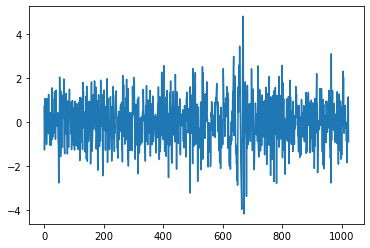

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

noisy_data = hf['y_data_noisy'][:]
plt.plot(noisy_data[0,1,:])

(1, 1, 4)

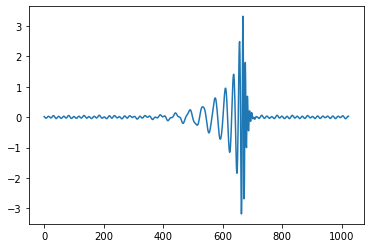

In [22]:
clean_data = hf['y_data_noisefree'][:]
plt.plot(clean_data[0,1,:])

signal_train_pars.shape

In [15]:
new_d_scale = np.random.rand()
new_d = bounds['luminosity_distance_min'] + new_d_scale*(bounds['luminosity_distance_max'] - bounds['luminosity_distance_min'])
dist_scale = new_d/signal_train_pars[0,0,2]

In [17]:
y_normscale = 16.638832624721797
clean_data = (clean_data*dist_scale + np.random.normal(loc = 0.0, scale = 1.0, size = clean_data.shape))/y_normscale

In [18]:
white_noise = (np.random.normal(loc = 0.0, scale = 1.0, size = clean_data.shape))/y_normscale

In [23]:
temp_signal = clean_data*dist_scale/y_normscale

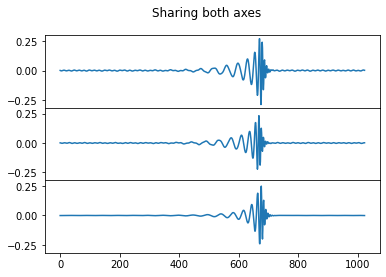

In [24]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
det_list = ["L1","H1","V1"]
for i in range(3):
    axs[i].plot(temp_signal[0,i,:], label = '%s' % (det_list[i]))

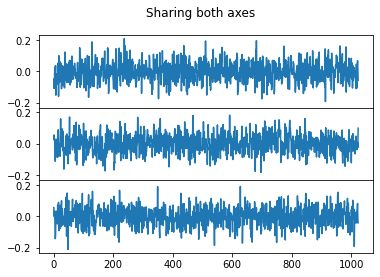

In [20]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
det_list = ["L1","H1","V1"]
for i in range(3):
    axs[i].plot(white_noise[0,i,:], label = '%s' % (det_list[i]))

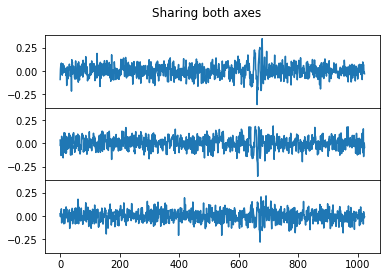

In [21]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
det_list = ["L1","H1","V1"]
for i in range(3):
    axs[i].plot(clean_data[0,i,:], label = '%s' % (det_list[i]))

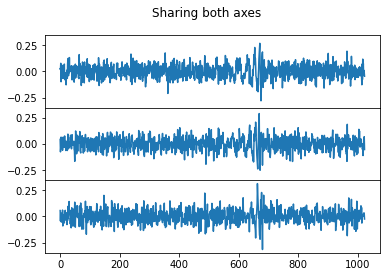

In [26]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
det_list = ["L1","H1","V1"]
for i in range(3):
    axs[i].plot(noisy_data[0,i,:]/y_normscale, label = '%s' % (det_list[i]))